In [1]:
import numpy as np
from tqdm import tqdm
from scipy.integrate import trapz, simpson
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

In [2]:
cmap = plt.get_cmap('viridis')
cmap.set_bad(color = 'grey')

## Compare PINN to (more accurate) PINN with fixed parameters

In [8]:
nx, ny, ntheta = 101, 101, 29
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
theta = np.linspace(-np.pi, np.pi, ntheta)
theta_zero = np.argmin(np.abs(theta))

theta_max = 0.25*np.pi
theta_max_ind = np.any([theta == theta_max, theta == -theta_max], axis=0)
if np.sum(theta_max_ind) != 0:
    print(np.nonzero(theta_max_ind))
else:
    ntheta += 2
    theta = np.concatenate([theta, np.array([theta_max, -theta_max])])
    theta = np.sort(theta)
    theta_max_ind = np.any([theta == theta_max, theta == -theta_max], axis=0)
    print(np.nonzero(theta_max_ind))

#u_abs_num = np.load('u_abs_num.npy')
#u_abs_num = u_abs_num[:,:,np.abs(theta)!=0.25*np.pi]
#u_sca_num = np.load('u_sca_num.npy')
#u_sca_num = u_sca_num[:,:,np.abs(theta)!=0.25*np.pi]
theta = theta[np.abs(theta)!=0.25*np.pi]
u_abs_PINN = np.load('../data/u_abs_PINN.npy')
u_sca_PINN = np.load('../data/u_sca_PINN.npy')
u_sca_PINN += u_abs_PINN
u_abs_fixedPINN = np.load('../data/u_abs_fixedPINN.npy')
u_sca_fixedPINN = np.load('../data/u_sca_fixedPINN.npy')
u_sca_fixedPINN += u_abs_fixedPINN

#diff_num = u_sca_num - u_abs_num
diff_PINN = u_sca_PINN - u_abs_PINN
diff_fixedPINN = u_sca_fixedPINN - u_abs_fixedPINN

(array([11, 19]),)


In [9]:
comp1_abs = u_abs_fixedPINN
comp1_sca = u_sca_fixedPINN
comp1_dif = diff_fixedPINN

comp2_abs = u_abs_PINN
comp2_sca = u_sca_PINN
comp2_dif = diff_PINN

i_dir = 0

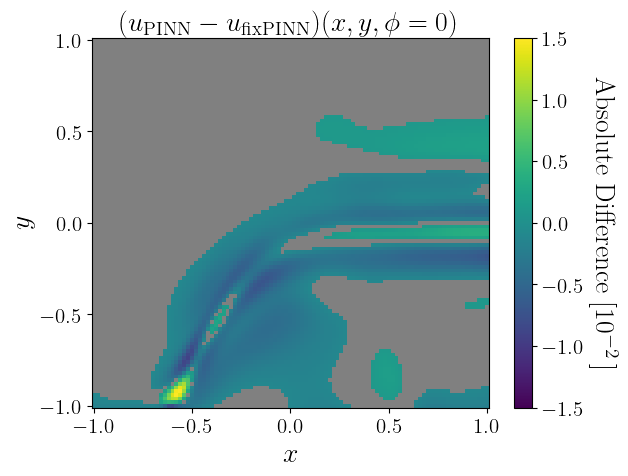

In [16]:
fontsize = 15
diff_sca = comp2_sca - comp1_sca
diff_sca[np.abs(diff_sca)<0.001] = np.nan
pcm = plt.pcolormesh(x[:],y[:], 100*diff_sca[:,:,theta_zero+i_dir].T, cmap=cmap, vmin=-1.5, vmax=1.5)
cb = plt.colorbar(pcm)
cb.ax.tick_params(labelsize=fontsize)
cb.set_label(r'Absolute Difference $[10^{-2}\,]$', rotation=270, fontsize=fontsize+5, labelpad=25)
#cb.ax.set_title(r'$\times 10^{-2}$', fontsize=fontsize, position=(1,1))
plt.xticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.yticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.xlabel(r'$x$', fontsize=fontsize+5)
plt.ylabel(r'$y$', fontsize=fontsize+5)
plt.title(r'$(u_\mathrm{PINN} - u_\mathrm{fixPINN}) (x,y,\phi=0)$', fontsize=fontsize+5)
plt.savefig('../images/fixPINN_diff.png', dpi=200)

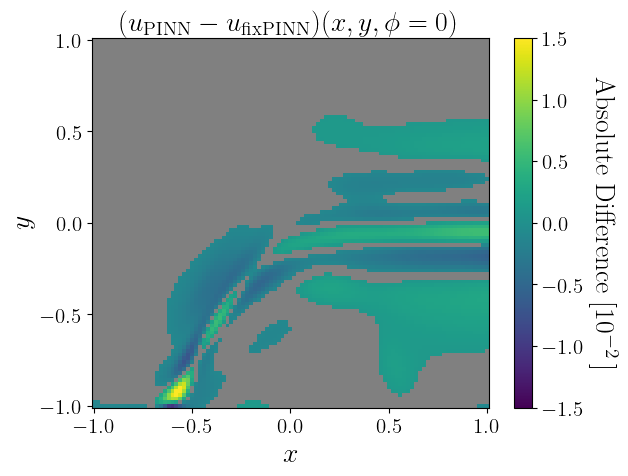

In [15]:
# Compare only absorption component
diff_abs = comp2_abs - comp1_abs
diff_abs[np.abs(diff_abs)<0.001] = np.nan
pcm = plt.pcolormesh(x[:],y[:], 100*diff_abs[:,:,theta_zero+i_dir].T, cmap=cmap, vmin=-1.5, vmax=1.5)
cb = plt.colorbar(pcm)
cb.ax.tick_params(labelsize=fontsize)
cb.set_label(r'Absolute Difference $[10^{-2}\,]$', rotation=270, fontsize=fontsize+5, labelpad=25)
#cb.ax.set_title(r'$\times 10^{-2}$', fontsize=fontsize, position=(1,1))
plt.xticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.yticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.xlabel(r'$x$', fontsize=fontsize+5)
plt.ylabel(r'$y$', fontsize=fontsize+5)
plt.title(r'$(u_\mathrm{PINN} - u_\mathrm{fixPINN}) (x,y,\phi=0)$', fontsize=fontsize+5)

Text(0.5, 1.0, '$(u_\\mathrm{PINN} - u_\\mathrm{fixPINN}) (x,y,\\phi=0)$')

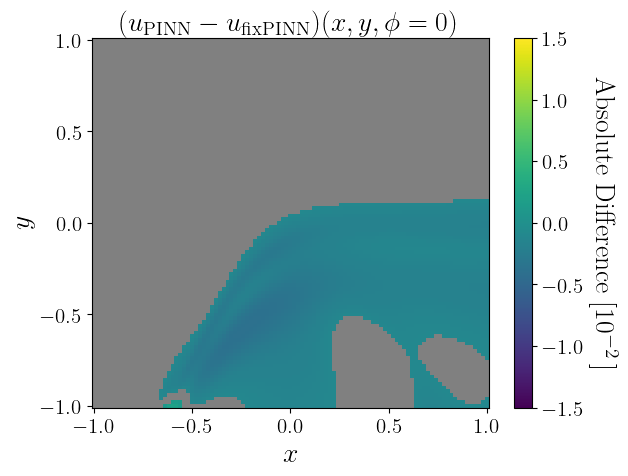

In [17]:
# Compare only scattering component
diff_diff = comp2_dif - comp1_dif
diff_diff[np.abs(diff_diff)<0.001] = np.nan
pcm = plt.pcolormesh(x[:],y[:], 100*diff_diff[:,:,theta_zero+i_dir].T, cmap=cmap, vmin=-1.5, vmax=1.5)
cb = plt.colorbar(pcm)
cb.ax.tick_params(labelsize=fontsize)
cb.set_label(r'Absolute Difference $[10^{-2}\,]$', rotation=270, fontsize=fontsize+5, labelpad=25)
#cb.ax.set_title(r'$\times 10^{-2}$', fontsize=fontsize, position=(1,1))
plt.xticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.yticks(np.linspace(-1,1,5), fontsize=fontsize)
plt.xlabel(r'$x$', fontsize=fontsize+5)
plt.ylabel(r'$y$', fontsize=fontsize+5)
plt.title(r'$(u_\mathrm{PINN} - u_\mathrm{fixPINN}) (x,y,\phi=0)$', fontsize=fontsize+5)

In [ ]:
# Compare total loss between the standard PINN and the hard-BC variant
import csv
import io
from contextlib import redirect_stdout
from pathlib import Path

import torch

from ImportFile import *  # brings in Ec, DefineDataset, CustomLoss, etc.

root_dir = Path('..')
standard_dir = root_dir / 'models' / 'RayleighOnly_lxlynorm_lowBC01_4+2x64_400x50_2'
hard_bc_dir = root_dir / 'models' / 'RayleighOnly_hardBC_4+2x64_400x50_2'

# Utility helpers
def load_network_properties(csv_path):
    with open(csv_path, 'r', newline='') as handle:
        reader = csv.DictReader(handle)
        row = next(reader)
    return {
        'hidden_layers': int(row['hidden_layers']),
        'neurons': int(row['neurons']),
        'residual_parameter': float(row['residual_parameter']),
        'kernel_regularizer': int(row['kernel_regularizer']),
        'regularization_parameter': float(row['regularization_parameter']),
        'batch_size': int(row['batch_size']),
        'epochs': int(row['epochs']),
        'activation': row['activation'],
    }


def load_dataset_counts(info_path):
    with open(info_path, 'r') as handle:
        headers = handle.readline().strip().split(',')
        values = handle.readline().strip().split(',')
    raw = dict(zip(headers, values))
    return {
        'N_coll': int(float(raw['Nf_train'])),
        'N_u': int(float(raw['Nu_train'])),
        'N_int': int(float(raw['Nint_train'])),
    }


def build_dataset(counts, batch_size, seed=42):
    space_dims = Ec.space_dimensions
    time_dims = Ec.time_dimensions
    if time_dims == 0:
        n_initial = 0
        n_boundary = int(counts['N_u'] / (2 * space_dims))
    else:
        n_boundary = int(counts['N_u'] / (4 * space_dims))
        n_initial = counts['N_u'] - 2 * space_dims * n_boundary
    dataset = DefineDataset(
        Ec.extrema_values,
        Ec.parameters_values if hasattr(Ec, 'parameters_values') else None,
        Ec.type_of_points_dom if hasattr(Ec, 'type_of_points_dom') else 'uniform',
        counts['N_coll'],
        n_boundary,
        n_initial,
        counts['N_int'],
        batches=batch_size,
        output_dimension=Ec.output_dimension,
        space_dimensions=space_dims,
        time_dimensions=time_dims,
        parameter_dimensions=getattr(Ec, 'parameter_dimensions', 0),
        random_seed=seed,
        obj=getattr(Ec, 'obj', None),
        shuffle=False,
        type_point_param=getattr(Ec, 'type_of_points', None),
    )
    dataset.assemble_dataset()
    return dataset


def load_model(model_dir, device):
    model_path = Path(model_dir) / 'TrainedModel' / 'model.pkl'
    model = torch.load(model_path, map_location=device)
    model.eval()
    return model.to(device)


def total_log_loss(model, dataset, device):
    loss_fn = CustomLoss()
    losses = []
    buffer = io.StringIO()
    with torch.enable_grad():
        with redirect_stdout(buffer):
            coll_loader = dataset.data_coll
            b_loader = dataset.data_boundary
            iu_loader = dataset.data_initial_internal

            if len(b_loader) != 0 and len(iu_loader) != 0:
                iterator = zip(coll_loader, b_loader, iu_loader)
                for (x_coll, _), (x_b, u_b), (x_u, u) in iterator:
                    x_coll = x_coll.to(device)
                    x_b, u_b = x_b.to(device), u_b.to(device)
                    x_u, u = x_u.to(device), u.to(device)
                    loss = loss_fn(model, x_u, u, x_b, u_b, x_coll, None, None, dataset, False)
                    losses.append(loss.detach().cpu())
            elif len(b_loader) == 0 and len(iu_loader) != 0:
                iterator = zip(coll_loader, iu_loader)
                for (x_coll, _), (x_u, u) in iterator:
                    x_coll = x_coll.to(device)
                    x_u, u = x_u.to(device), u.to(device)
                    dummy = torch.zeros((0, 1), device=device)
                    loss = loss_fn(model, x_u, u, dummy, dummy, x_coll, None, None, dataset, False)
                    losses.append(loss.detach().cpu())
            elif len(b_loader) != 0 and len(iu_loader) == 0:
                iterator = zip(coll_loader, b_loader)
                for (x_coll, _), (x_b, u_b) in iterator:
                    x_coll = x_coll.to(device)
                    x_b, u_b = x_b.to(device), u_b.to(device)
                    dummy = torch.zeros((0, 1), device=device)
                    loss = loss_fn(model, dummy, dummy, x_b, u_b, x_coll, None, None, dataset, False)
                    losses.append(loss.detach().cpu())
            else:
                raise RuntimeError('Dataset has neither boundary nor initial samples to evaluate.')
    buffer.close()
    stacked = torch.stack(losses)
    mean_log = stacked.mean().item()
    rmse = float((10 ** mean_log) ** 0.5)
    return mean_log, rmse

# Load configs and datasets
standard_props = load_network_properties(standard_dir / 'TrainedModel' / 'Information.csv')
standard_counts = load_dataset_counts(standard_dir / 'InfoModel.txt')
hard_counts = load_dataset_counts(hard_bc_dir / 'InfoModel.txt')
assert standard_counts == hard_counts, 'Training sets differ between the two models.'

device = Ec.dev
torch.manual_seed(42)
dataset = build_dataset(standard_counts, standard_props['batch_size'], seed=42)

# Load models
standard_model = load_model(standard_dir, device)
hard_model = load_model(hard_bc_dir, device)

# Evaluate
standard_log, standard_rmse = total_log_loss(standard_model, dataset, device)
hard_log, hard_rmse = total_log_loss(hard_model, dataset, device)

print(f'Standard PINN log10-loss: {standard_log:.4f} (RMSE {standard_rmse:.4e})')
print(f'Hard-BC PINN log10-loss: {hard_log:.4f} (RMSE {hard_rmse:.4e})')
print(f'Hard-BC gain (log10-loss difference): {hard_log - standard_log:.4f}')
